In [1]:
import numpy as np
from scipy.spatial import distance
from scipy import linalg
from sklearn.cluster import SpectralClustering, KMeans
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets.samples_generator import make_circles
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import networkx as nx
import seaborn as sns

C:\Users\germa\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


<h4>Генерация данных и пример кластеризации методом K-means</h4>

Text(0.5, 1.0, 'KMeans clustering')

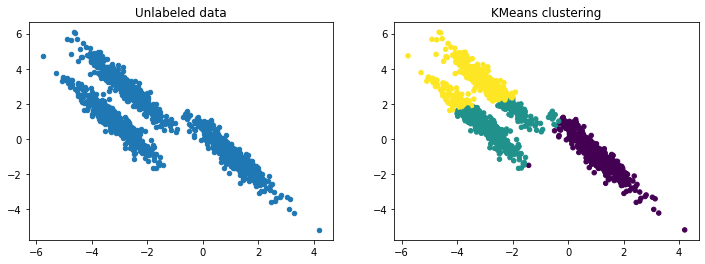

In [2]:
# Создаю выборку: 3 вытянутых кластера 
n_samples = 1500
RSEED = 170  # константа для random_state
X, y = make_blobs(n_samples = n_samples, random_state = RSEED)
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)

plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], s = 20)
plt.title("Unlabeled data")

y_pred = KMeans(n_clusters = 3, random_state = RSEED).fit_predict(X_aniso)
plt.subplot(1, 2, 2)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c = y_pred, s = 20)
plt.title("KMeans clustering")


K-means не увидел структуры, так как в силу своей специфики хорошо распознает выпуклые кластеры в виде компактных "облаков", а с невыпуклыми кластерами у него проблемы

Алгоритм спектральной кластеризации способен выявлять невыпуклые формы кластеров. На основе имеющихся данных алгоритм создает новое, более удобное признаковое пространство, с которым впоследствии сможет справиться даже простой алгоритм, вроде K-means, и адекватно разделить кластеры.

Чтобы воспользоваться данным методом, надо:
<ul>
    <li>Построить граф схожести. Есть три популярных способа: односвязный граф, граф k-ближайших соседей, epsilon-neigbourhood graph</li>
    <li>Задать нормированный или ненормированный лаплассиан этого графа</li>
    <li>Используя свойства лаплассиана, создать новое признаковое пространство</li>
    <li>Применить к новому признаковому пространству любой алгоритм кластеризации. Например, K-means</li>
<ul>


<h4>Формула для задания весов связного графа:</h4>

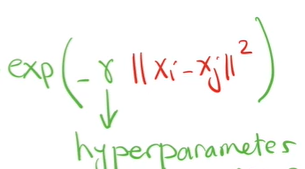

In [3]:
# гипермараметр для задания весов у ребер графа
gamma = 7.6
# матрица евклидовых расстояний между точками датасета
dist_matrix = distance.cdist(X_aniso, X_aniso, metric = 'sqeuclidean')
# задаем веса для ребер графа, прогоняя через экспоненту(чтобы веса были от 0 до 1). K - матрица смежности
K = np.exp(-gamma * dist_matrix)


<h4>Метод с использованием ненормированного Лаплассиана</h4>

In [4]:
# Диагональная матрица
D = np.diag(np.sum(K, axis = 1))
# Лапласиан. Задается разностью диагональной матрицы и матрицы смежности
L = D - K

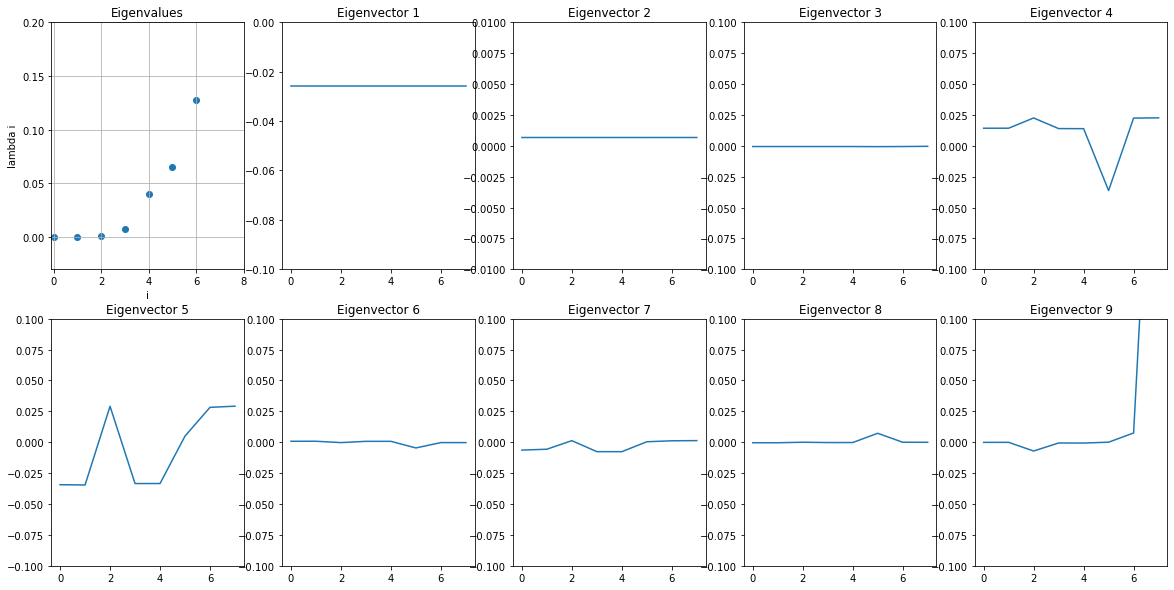

In [5]:
e, v = linalg.eigh(L, subset_by_index = [0, 15])

plt.figure(figsize = (20, 10))

plt.subplot(2, 5, 1).set_title('Eigenvalues')
plt.xlabel("i")
plt.ylabel("lambda i")
plt.scatter(range(len(e)), e)
plt.grid(True)
plt.xlim(-0.1, 8)
plt.ylim(-0.03, 0.2)


plt.subplot(2, 5, 2).set_title('Eigenvector 1')
plt.plot(range(0, 8), v[:, 0][0:8])
plt.ylim(-0.1, 0)

plt.subplot(2, 5, 3).set_title('Eigenvector 2')
plt.plot(range(0, 8), v[:, 1][0:8])
plt.ylim(-0.01, 0.01)

plt.subplot(2, 5, 4).set_title('Eigenvector 3')
plt.plot(range(0, 8), v[:, 2][0:8])
plt.ylim(-0.1, 0.1)

plt.subplot(2, 5, 5).set_title('Eigenvector 4')
plt.plot(range(0, 8), v[:, 3][0:8])
plt.ylim(-0.1, 0.1)

plt.subplot(2, 5, 6).set_title('Eigenvector 5')
plt.plot(range(0, 8), v[:, 4][0:8])
plt.ylim(-0.1, 0.1)

plt.subplot(2, 5, 7).set_title('Eigenvector 6')
plt.plot(range(0, 8), v[:, 5][0:8])
plt.ylim(-0.1, 0.1)

plt.subplot(2, 5, 8).set_title('Eigenvector 7')
plt.plot(range(0, 8), v[:, 6][0:8])
plt.ylim(-0.1, 0.1)

plt.subplot(2, 5, 9).set_title('Eigenvector 8')
plt.plot(range(0, 8), v[:, 7][0:8])
plt.ylim(-0.1, 0.1)

plt.subplot(2, 5, 10).set_title('Eigenvector 9')
plt.plot(range(0, 8), v[:, 8][0:8])
plt.ylim(-0.1, 0.1)

plt.show()

Первые 3 с.з равны нулю, соответствующие им собств.векторы - константные. В 4 и 5 собств.векторах содержится практически вся нужная  информация о кластерах, что можно наблюдать на графиках

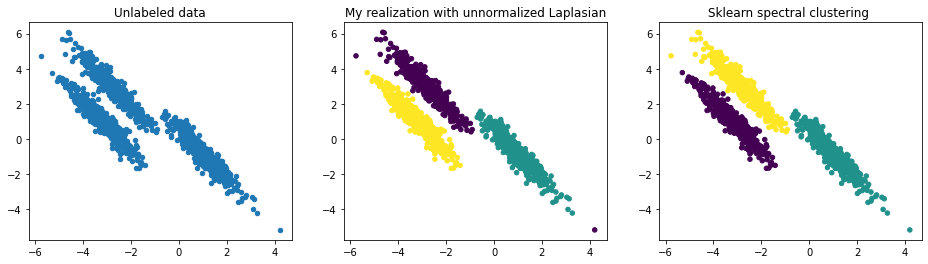

In [6]:
# Ищем наименьшие с.з. и соответствующие им с.в
e, v = linalg.eigh(L, subset_by_index = [3, 3]) # с.з. с индексами 0,1,2 фактически приравнять к нулю, поэтому в качестве
                                                # 
y_pred_sc = KMeans(n_clusters = 3, random_state = RSEED).fit_predict(v)

plt.figure(figsize = (16, 4))
plt.subplot(131)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], s = 20)
plt.title("Unlabeled data")

plt.subplot(132)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c = y_pred_sc, s = 20)
plt.title("My realization with unnormalized Laplasian")

y_pred_sklearn_sc = SpectralClustering(n_clusters = 3, gamma = 7.6).fit_predict(X_aniso)
plt.subplot(133)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c = y_pred_sklearn_sc, s = 20)
plt.title("Sklearn spectral clustering ")

plt.show()

Алгоритм уловил структуру кластеров, результат почти идентичный с реализацией sklearn, за исключением двух выбросов

<h4>Теперь реализация с использованием нормированного Лаплассиана</h4>

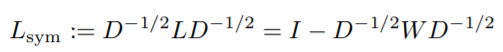

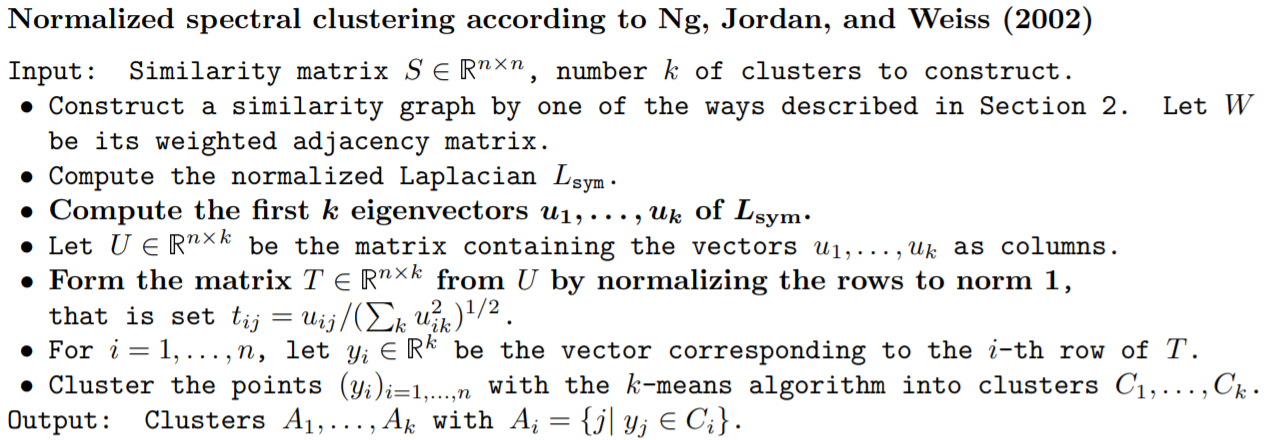

In [45]:
# Нормированный лаплассиан Lsym
D = K.sum(axis = 1)
D = np.sqrt(1/D)
Lsym = np.multiply(D[np.newaxis, : ], np.multiply(L, D[:, np.newaxis]))

Взглянем на собственные значения и собственные векторы нормированного лапласиана

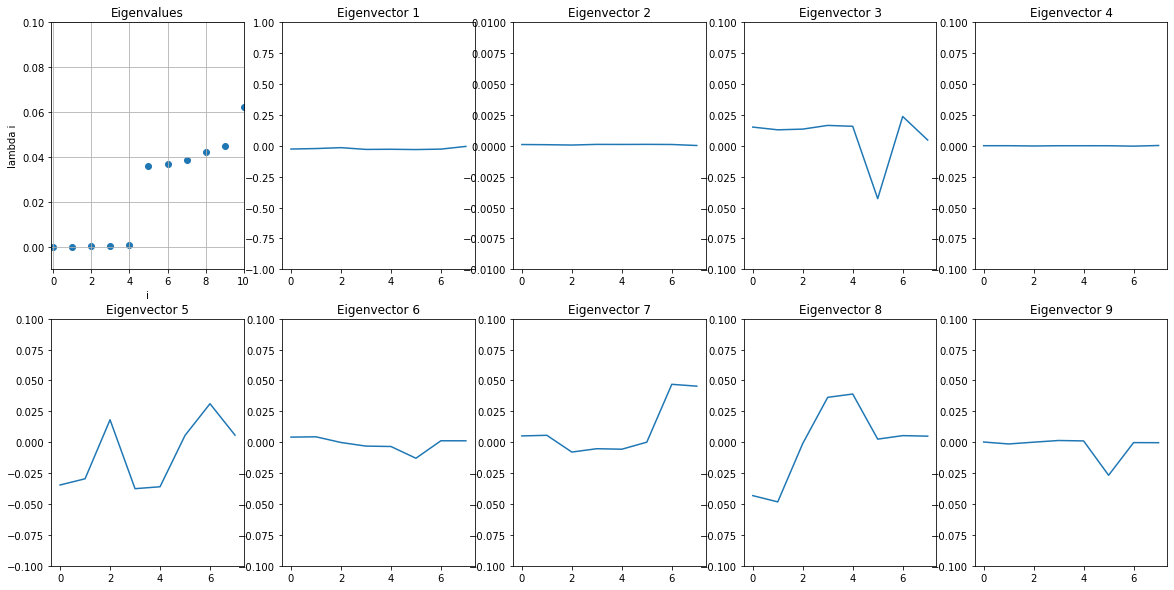

In [55]:
Esym, Vsym = linalg.eigh(Lsym, subset_by_index = [0, 15])

plt.figure(figsize = (20, 10))

plt.subplot(2, 5, 1).set_title('Eigenvalues')
plt.xlabel("i")
plt.ylabel("lambda i")
plt.scatter(range(len(Esym)), Esym)
plt.grid(True)
plt.xlim(-0.1, 10)
plt.ylim(-0.01, 0.1)


plt.subplot(2, 5, 2).set_title('Eigenvector 1')
plt.plot(range(0, 8), Vsym[:, 0][0:8])
plt.ylim(-1, 1)

plt.subplot(2, 5, 3).set_title('Eigenvector 2')
plt.plot(range(0, 8), Vsym[:, 1][0:8])
plt.ylim(-0.01, 0.01)

plt.subplot(2, 5, 4).set_title('Eigenvector 3')
plt.plot(range(0, 8), Vsym[:, 2][0:8])
plt.ylim(-0.1, 0.1)

plt.subplot(2, 5, 5).set_title('Eigenvector 4')
plt.plot(range(0, 8), Vsym[:, 3][0:8])
plt.ylim(-0.1, 0.1)

plt.subplot(2, 5, 6).set_title('Eigenvector 5')
plt.plot(range(0, 8), Vsym[:, 4][0:8])
plt.ylim(-0.1, 0.1)

plt.subplot(2, 5, 7).set_title('Eigenvector 6')
plt.plot(range(0, 8), Vsym[:, 5][0:8])
plt.ylim(-0.1, 0.1)

plt.subplot(2, 5, 8).set_title('Eigenvector 7')
plt.plot(range(0, 8), Vsym[:, 6][0:8])
plt.ylim(-0.1, 0.1)

plt.subplot(2, 5, 9).set_title('Eigenvector 8')
plt.plot(range(0, 8), Vsym[:, 7][0:8])
plt.ylim(-0.1, 0.1)

plt.subplot(2, 5, 10).set_title('Eigenvector 9')
plt.plot(range(0, 8), Vsym[:, 8][0:8])
plt.ylim(-0.1, 0.1)

plt.show()

Первые 2 вектора - константные. Следующие векторы содержат информацию о кластерах. Проведя эксперименты и оценив результаты, пришел к выводу, что оптимально будет взять 3, 4 и 5 векторы

Теперь зададим матрицу Т, которая представляет собой вторую норму по строкам Лапласиана

In [62]:
Esym, Vsym = linalg.eigh(Lsym, subset_by_index = [2, 4])

T = np.zeros((Vsym.shape[0], Vsym.shape[1]))

for i in range(0, Vsym.shape[0]):
    for j in range(0, Vsym.shape[1]):
        T[i][j] = Vsym[i][j]/linalg.norm(Vsym[i], ord = 2)

# Вывод нормированной матрицы
print(T)

[[ 4.00058839e-01  6.84680951e-04 -9.16489202e-01]
 [ 3.99506228e-01  8.65280145e-04 -9.16730072e-01]
 [ 5.94871031e-01 -8.43774847e-03  8.03776873e-01]
 ...
 [-9.91319348e-01  1.85209307e-05  1.31476044e-01]
 [-9.99072878e-01  1.01378686e-05  4.30509600e-02]
 [-9.91409261e-01  1.84605687e-05  1.30796320e-01]]


Результаты. На графике слева - набор данных. На графике справа - результат алгоритма K-means на новом признаковом пространстве, составленном из собственных векторов нормированного Лапласиана

Text(0.5, 1.0, 'My realization with normalized Laplasian')

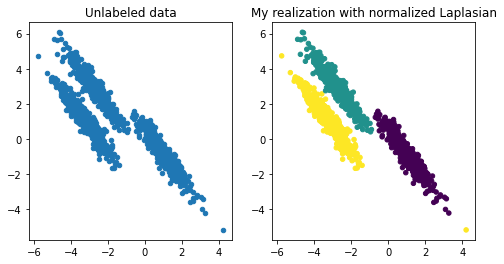

In [61]:
y_pred_norm_laplasian = KMeans(n_clusters = 3).fit_predict(T)

plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], s = 20)
plt.title("Unlabeled data")

plt.subplot(1, 2, 2)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c = y_pred_norm_laplasian, s = 20)
plt.title("My realization with normalized Laplasian")